# Assignment 4 – Robot in a maze

In the  fourth assignment, you will delve into the application of RL algorithms to address the real-world challenge of navigating a robot through a maze dubbed 'robot in a maze'. The primary objectives of this assignment include:

 -   Formalizing a practical problem into a Markov Decision Process (MDP).
 -   Gaining familiarity with the OpenAI Gym framework (recently renamed as Gymnasium) and utilizing it to implement RL agents.
 -   Applying SARSA and Q-learning algorithms to solve the 'robot in a maze' MDP problem.
 -   Evaluating the outcomes of the reinforcement learning process and interpreting your findings.
 -   Reflecting on the distinctions between the two types of RL algorithms employed.

By accomplishing these objectives, you will not only enhance your understanding of RL algorithms but also develop practical skills in formulating and solving complex problems in the context of autonomous navigation within a maze.

In this assignment, you will be developing a robot to navigate its way through a maze. The project is divided into three parts (5 subtasks).

  1. In the first part, you will familiarize yourself with the OpenAI Gym/Gymnasium framework.
  2. In the second part, we have implemented the environment for you based on the Gym/Gymnasium framework. Your tasks include:  
     2.1. formalizing the problem as an MDP model,    
     2.2. implementing your own RL agents, and      
     2.3. training them to find the shortest route out of a maze.
  3. Finally, in the third part, you will evaluate and interpret the results obtained from the implemented RL agents


## 1. OpenAI gym

Gym/Gymnasium (https://gymnasium.farama.org/) is a widely used standard toolkit for developing and comparing reinforcement learning algorithms. Gymnasium is the maintained fork of OpenAI’s Gym library (more on this recent change is available if you're interested: https://farama.org/Announcing-The-Farama-Foundation).

Gym/Gymnasium makes no assumptions about the structure of your agent and is compatible with any machine learning library, such as TensorFlow or Theano.

The library is a collection of test problems — environments — that you can use to develop your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

First, we download and install the Gym/Gymnasium library. Then, import the Gymnasium class.

In [1]:
# !pip install gymnasium


We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- In MDP problems, such as ours, the **ENVIRONMENT** provides an **OBSERVATION**, which represents the state of the **ENVIRONMENT** at the current moment.
- The agent takes an **ACTION** based on its **OBSERVATION**,
<!-- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value. -->
- When the agent takes an ACTION, the ENVIRONMENT assesses the effectiveness of the action and generates a REWARD, which is usually a numeric value.

Please read the 'Basic usage' https://gymnasium.farama.org/content/basic_usage/ for better understanding the framework.  And do not forget import gymnasium before running other codes.

In [2]:
import gymnasium as gym
from matplotlib import pyplot as plt

 ## 2. Tasks

Next, you will tackle a practical Markov Decision Process (MDP) problem, the 'robot in a maze,' based on the gym framework. Your task involves implementing an RL agent and training it to discover the shortest route to achieve the maze goal. In this MDP, the environment is represented as a grid world (a maze), with the agent being a robot. At each time step, the robot begins at a random location and can move within the grid world. The overarching objective is to find the way out, reaching the final location. Consequently, you will need to identify a fixed goal position within the maze.

### 2.1 Model the practical task into a MDP

To solve a RL problem, we start with formalizing the problem into a MDP model. Please describe this MDP model in your report. 

Notice: No empricial data provided in this assignment, so the point of 'data description and exploration' will be given to this step. 

While exploring your MDP model, you shall think about questions such as:
- What is the environment? How does it look like?
- What simulated data can your RL agent observe from the environment? How does it look like?
- Which data is considered as the state? Which data is considered as the reward?

#### Set up the environment

There is no need to implement your own environment; you should use the environment provided in the file **environment.py**. However, please ensure to take a look at it so that you understand the inner workings of this environment.

The core gym interface is **Env**, which serves as the unified environment interface. The following are the Env methods you should be familiar with:

- reset(self): Reset the environment's state and return the observation.
- step(self, action): Advance the environment by one timestep and return the observation, reward, done, and info.
- render(self, mode='rgb_array'): Render one frame of the environment. The default mode will produce something human-friendly, such as pop up a window. However, in this assignment, there is no need to create a pop-up window.

Please note that you need to install the [mazelab](https://github.com/yupei-du/mazelab.git) package, from **Yupei Du's** repository, to run the environment (a file with required packages is also provided). If you run the cell below for the first time, make sure to restart the IPython notebook at least once.


In [3]:
# !git clone https://github.com/yupei-du/mazelab.git
# !pip3 install -e ../mazelab
# !pip3 install pandas
# !pip3 install seaborn

You can now check whether the required packages (e.g. mazela, pandas, tqdm, seaborn) are installed. Please install the ones are missing. 

ATTENTION: To run the given code, please use the python version 3.7-3.9, and the numpy version < 1.23

In [4]:
# conda list

We also provide a few helper functions to make it easier to debug your agents. 
 - `animate_run` will enable you to see the agent's behavior. It takes a list of images which can be produced by the `env.render` function of the environment
 - `visualize_agent_brain` will provide you with a way to visualize the agents learned q_table. Use it after you have implemented and trained your agents. The first plot will show the highest q-value per state (position on the map) and the second will tell you which action the agent would choose at that state/position. It takes the environment and the agent as input.

Below you will find a basic example of how the animation function works. Please notice that: whenever you **reset()** the environment, the agent will start at a random position (a different state). 

### 2.2  Implement the agents 

In this part, you are expected to implement two RL agents. 

- Agent 1 uses the Q-learning algorithm to learn the optimal solution
- Agent 2 uses the SARSA algorithm to learn the optimal solution. To decide the action to take at each time step,  this agent uses the epsilon greedy action selection.

Here, we have also provided an example agent: the Random Agent.  It follows a random policy to move at each step (randomly selecting an action). You can use this example agent as a baseline to evaluate your agents.


In [5]:
import sys
sys.path.append("../")


In [6]:
from others.environment import TaskEnv
from typing import Tuple, List
import numpy as np
import random
from mazelab import VonNeumannMotion
from icecream import ic
from tqdm import tqdm
import seaborn as sns
from IPython import display

In [7]:
def animate_run(data:List[np.ndarray]):
    init_img = data[0]
    remaining_img = data[1:]
    img_container = plt.imshow(init_img)  # only call this once
    for img in remaining_img:
        img_container.set_data(img)  # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)


def visualize_agent_brain(agent, env: TaskEnv):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title("Highest state value at position (x,y)")
    state_value_map = agent.q_table.max(axis=2)
    sns.heatmap(state_value_map, ax=ax1)

    ax2.set_title("Chosen action at position (x,y)")
    n = env.action_space.n + 1
    path = env.maze.objects.free.positions
    decisions_map = np.array([[x_, y_, agent.select_action([x_, y_],  use_greedy_strategy = True) + 1] for x_, y_ in path])
    state_action_map = np.zeros_like(agent.q_table.max(axis=2))
    state_action_map[decisions_map[:, 0], decisions_map[:, 1]] = decisions_map[:, 2]
    cmap = sns.color_palette("tab10", n)
    sns.heatmap(state_action_map, cmap=cmap, ax=ax2)
    colorbar = ax2.collections[0].colorbar
    r = (colorbar.vmax) - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(['N/A', 'north', 'south', 'west', 'east'])
    fig.tight_layout()
    return plt.show()

In [8]:
directions_dic = {
    0:'north',
    1:'south',
    2:'west',
    3:'east'
}

In [9]:
# Random agent
class RandomAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = None,
                 learning_rate: float = None,
                 discount_factor: float = None) -> int:
        self.epsilon = 1  # A random agent "explores" always, so epsilon will be 1
        self.alpha = 0  # A random agent never learns, so there's no need for a learning rate
        self.gamma = 0  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        return None


    def solve(self, env: TaskEnv = None, starting_position : Tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        positions = []
        frames = []
        score = 0
        while(True):
            positions.append(current_state)
            frames.append(env.render())
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return positions, frames, score
            
    def score(self, env: TaskEnv = None, starting_position: tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        score = 0
        while(True):
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return score

In [10]:
# Random agent
class SARSAAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.1,
                 discount_factor: float = 0.9) -> int:
        self.epsilon = exploration_rate  
        self.alpha = learning_rate 
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action
        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        self.q_table[tuple(state)][action] +=  self.alpha * (\
                                    reward + 
                                    (self.gamma * self.q_table[tuple(next_state)][self.select_action(next_state)])
                                    -  self.q_table[tuple(state)][action]
                                    )
    def train(self, episodes = 10000, env:TaskEnv = None, disableTQDM = False):
        for _ in tqdm(range(episodes), disable = disableTQDM):
            current_state = env.reset()
            while True:
                action = self.select_action(state=current_state)  # agent policy that uses the observation and info
                next_state, reward, terminated, _ = env.step(action)
                self.learn(current_state, action, next_state, reward, None)
                current_state = next_state
                if terminated:
                    break

    def solve(self, env: TaskEnv = None, starting_position : Tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        positions = []
        frames = []
        score = 0
        while(True):
            positions.append(current_state)
            frames.append(env.render())
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return positions, frames, score
    def score(self, env: TaskEnv = None, starting_position: tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        score = 0
        while(True):
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return score


In [11]:
# Random agent
class QLearningAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.1,
                 discount_factor: float = 0.9) -> int:
        self.epsilon = exploration_rate  
        self.alpha = learning_rate 
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                # print("\t I chose a random action")
                return next_action
        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        # print("\t I chose a greedy action")
        return next_action

    def learn(self, state, action, next_state, reward, done):
        self.q_table[tuple(state)][action] +=  self.alpha * (\
                                    reward + 
                                    (self.gamma * self.q_table[tuple(next_state)][self.select_action(next_state, use_greedy_strategy=True)])
                                    -  self.q_table[tuple(state)][action]
                                    )
    def train(self, episodes = 10000, env:TaskEnv = None, disableTQDM = False):
        for _ in tqdm(range(episodes), disable = disableTQDM):
            current_state = env.reset()
            while True:
                action = self.select_action(state=current_state)  # agent policy that uses the observation and info
                next_state, reward, terminated, _ = env.step(action)
                self.learn(current_state, action, next_state, reward, None)
                current_state = next_state
                if terminated:
                    break

    def solve(self, env: TaskEnv = None, starting_position : Tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        positions = []
        frames = []
        score = 0
        while(True):
            positions.append(current_state)
            frames.append(env.render())
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return positions, frames, score
    def score(self, env: TaskEnv = None, starting_position: tuple[int, int] = None):
        current_state = env.reset()
        if starting_position: 
            assert (starting_position in env.maze.objects.free.positions)
            env.maze.objects.agent.positions[0] = starting_position
            current_state = starting_position
        score = 0
        while(True):
            action = self.select_action(state=current_state, use_greedy_strategy=True)
            next_state, reward, terminated, _ = env.step(action)
            score += reward
            current_state = next_state
            if terminated:
                return score


In [12]:
def printMaze(env : TaskEnv = None, starting_position : Tuple[int, int] = None):
    if starting_position: 
        assert (starting_position in env.maze.objects.free.positions)
        env.maze.objects.agent.positions[0] = starting_position
    plt.imshow(env.render(), interpolation='nearest')
    plt.show()

In [13]:
env = TaskEnv()
env.reset()

array([13, 10])

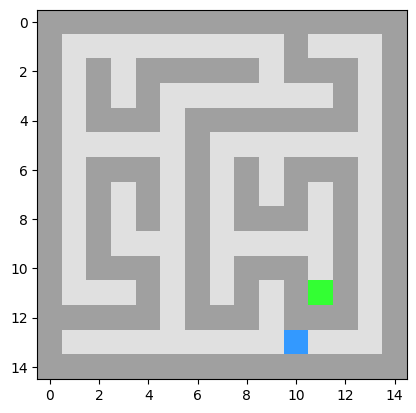

In [14]:
printMaze(env)

In [15]:
sagent = SARSAAgent(env)
qagent = QLearningAgent(env)

In [16]:
sagent.train(10000, env)
qagent.train(10000, env)

100%|██████████| 10000/10000 [00:10<00:00, 985.74it/s]


In [17]:
sdirections, sframes , sscore = sagent.solve(env, starting_position=[1,1])
qdirections, qframes , qscore = qagent.solve(env, starting_position=[1,1])
print(sscore, qscore)

-50.5 -9.809999999999999


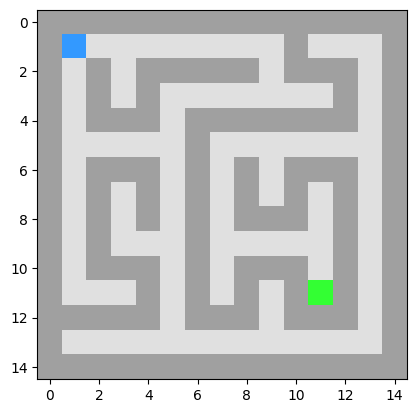

In [32]:
animate_run(sframes)

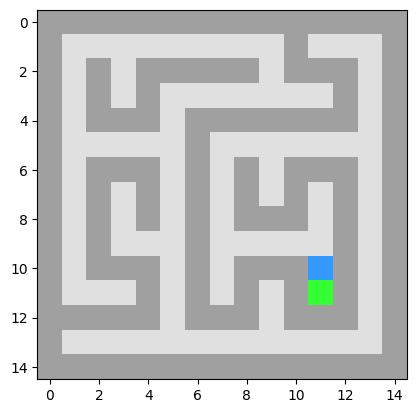

In [36]:
animate_run(qframes)

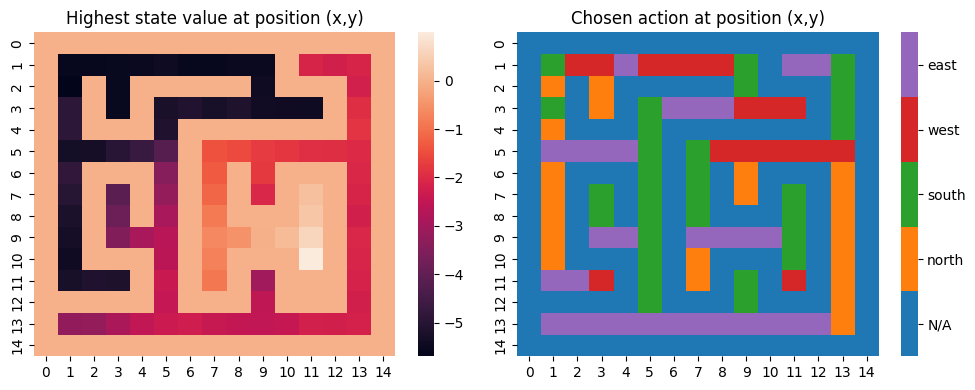

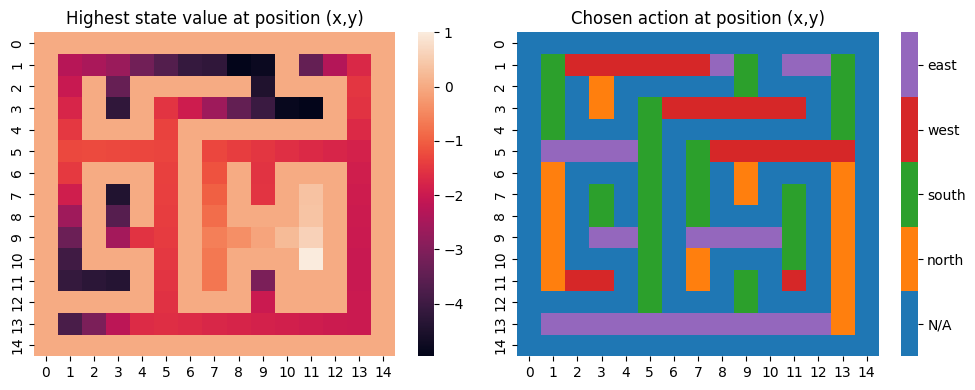

In [37]:
visualize_agent_brain(sagent, env)
visualize_agent_brain(qagent, env)

In [21]:
randomagent = RandomAgent(env)
directions, frames , score  = randomagent.solve(env)
print(score)

-78.63000000000001


In [22]:
sagent.score(env, [1,1]), qagent.score(env, [1,1])

(-50.5, -9.809999999999999)

### 2.3 Run the simulation

Now, you write code for running a simulation. In each run, you shall setup the epsilon parameter. 

In [23]:
# TODO: run the simulation

In [24]:
def get_starting_positions(env: TaskEnv = None, k: int = 5):
        gx, gy = env.goal_idx[0]
        dist = 3
        res = []
        while len(res) <= k:
            start_tmp = random.sample(list(env.maze.objects.free.positions), 1)[0]
            left_boundary, right_boundary = gx - dist, gx + dist
            upper_boundary, lower_boundary = gy - dist, gy + dist
            v_cond = start_tmp[0] not in range(left_boundary, right_boundary + 1)
            h_cond = start_tmp[1] not in range(upper_boundary, lower_boundary + 1)
            if v_cond or h_cond:
                  res.append(start_tmp.tolist())
        return res

get_starting_positions(env)

[[1, 8], [11, 3], [1, 12], [1, 11], [5, 10], [13, 3]]

In [25]:
def test_agent(env: TaskEnv = None, agent : SARSAAgent | QLearningAgent | RandomAgent = None, total_training=10000, step = 200):
    starting_positions = get_starting_positions(env)
    scores = []
    for _ in tqdm(np.arange(0,total_training, step)):
        agent.train(step,env, disableTQDM=True)
        sum = 0
        for position in starting_positions:
            sum += agent.score(env, position)
        scores.append(sum/6)
    return scores


In [46]:
newsagent = SARSAAgent(env)
newqagent = QLearningAgent(env)

In [47]:
total = 10000
step = 100

sscores = test_agent(env, newsagent, total_training=total, step=step)
qscores = test_agent(env, newqagent, total_training=total, step=step)

100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


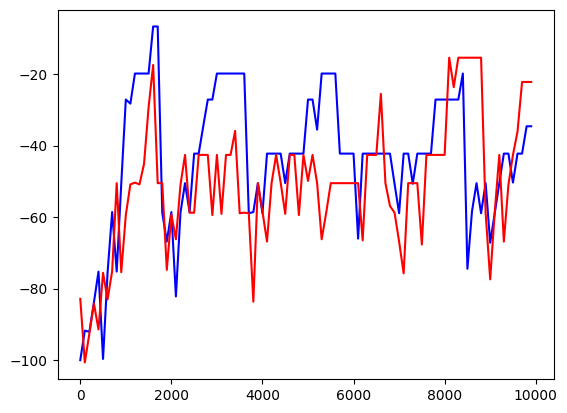

In [48]:
time = np.arange(0,total,step)
plt.plot(time, sscores, label = "SARSA", color = 'blue')
plt.plot(time, qscores, label = "Q Learner", color = 'red')
plt.show()

 ## 3. Play with parameters and analyse results
 
Finally, you will describe, evaluate, and interpret the results obtained from the two RL agents. Additionally, compare your agents with the provided Random Agent. Feel free to utilize the provided helper functions for evaluating your agents. Some important points are:

- Both quantified evaluation and human evaluation are needed in the report. The quantified evaluation should focus on the measurement of reward. In the human evaluation, you can use the provided visual tools to interpret your results. Your report should include at least one plot presenting comparable measures for the different agents.

- While evaluating the results of Agent 2 (with SARSA algorithm), please try at least 2 different values of **epsilon** (expect 0) and discuss the influence of different epsilon values on the results. In the end, please identify a reasonable epsilon value that could balance the exploration and exploitation, then fix this value for comparing the two agents. Present your trails and results in the report.

- In the report, you also need to parcitularly describe and discuss the similarity and difference of results from two RL agents (hint: on-policy VS off-policy). For this, please make sure that the compared results are obtained from the same environment (the same maze for two different agents). Also, while evaluating the results of two agents, please try at least 2 different values of **gamma**. In this way, you could discuss the influence of this discount factor in your report. 

- Please run the simulation multiple times and average the results for all your findings.


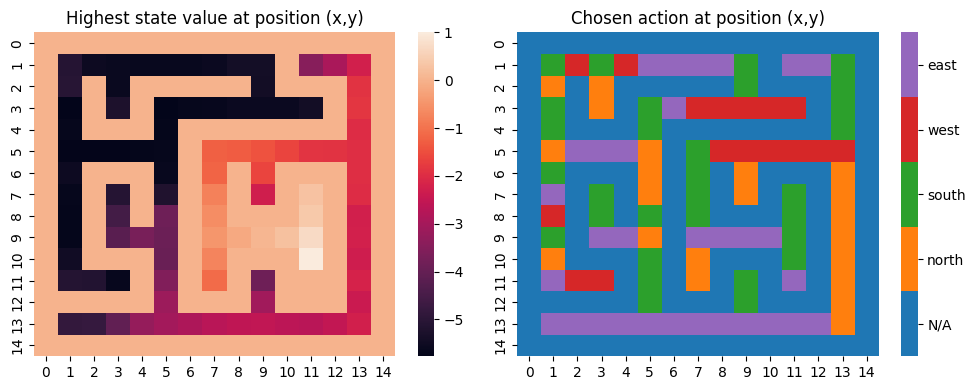

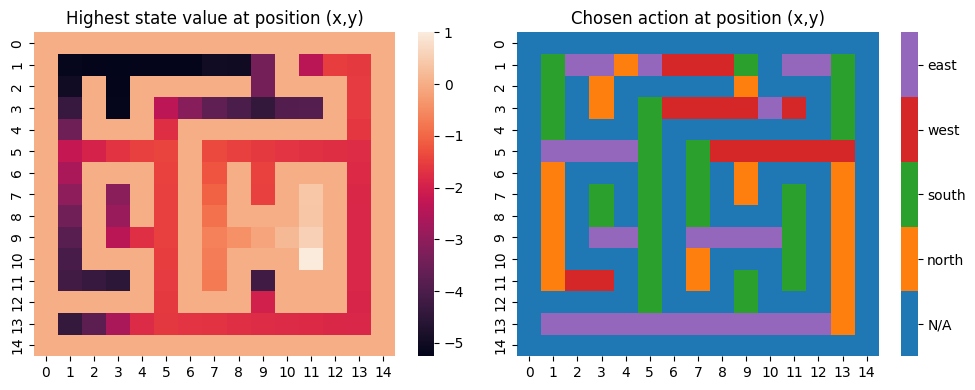

In [49]:
visualize_agent_brain(newsagent, env)
visualize_agent_brain(newqagent, env)

In [30]:
# TODO: evaluation 


# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement a third RL agent using another RL algorithm (e.g. Monte Carlo methods, Expected SARSA or even neural network-based ones) and discuss your findings. Compare this third agent with the above ones and explain why this is a better (or worse) RL algorithm. You are allowed to reuse exsiting packages, but please cite them, test them in advance, and make sure that you can explain the used algorithm using your own words.

2. Can you explore and show other evaluation results? If so, implement and present one extra result (e.g. a plot). And please explain why it is a good evaluation method for our task or how it shows the difference between two RL agents/algorithms.